<a href="https://colab.research.google.com/github/juancn95/saturdaysAI_titanic_challenge/blob/pdt_1/SaturdaysAI_titanic_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **El desafío del Titanic**
---

## **Visión general**
El hundimiento del Titanic es uno de los naufragios más infames de la historia. El 15 de abril de 1992, durante su viaje de inauguración, el considerado "no hundible" RMS Titanic, se hundió luego de colisionar con un iceberg. Desafortunadamente, no hubieron suficientes salvavidas para cada uno de los pasajeros a bordo, resultando en la muerte de más de 1502 personas, entre pasajeros y tripulación, para un total de 2224. 

Aunque habían elementos de buena suerte involucrados en la supervivencia, parece que ciertos grupos de personas tuvieron mayor probabilidad de sobrevivir que otras. 

En esta competencia, usando los datos de los pasajeros, tales como nombre, género, clase socio-económica, entre otros; se deberá construir un modelo predictivo que responda a la siguiente pregunta: ¿Cuáles fueron los grupos de personas con mayor probabilidad de sobrevivir? 

## **Objetivo**
- Predecir si cada uno de los pasajeros sobrevivió (1) o  no (0), tras el hundimiento del barco Titanic

## **Métrica**

La puntuación del modelo será el **porcentaje de pasajeros correctamente predecidos**, conocido también como **precisión**.

## **Formato del archivo de entrega**
El formato será un archivo de extensión `.csv` con 418 entradas con su correspondiente fila de encabezado, y solo deberá contener las columnas `PassengerID` y `Survived`. Si el archivo tiene una columna o fila extra, se remitirá un error. 

`PassengerID`: Ordenado en cualquier orden, sea ascendente o descendente. 

`Survived`: Contiene la **predicción binaria**: 1 para sobrevivió, 0 para fallecido.



# **Inicio**

## **Depencias**
**Manipulación de datos**: `pandas` `numpy` `scikit-learn`

**Visualización de datos**: `matplotlib` `seaborn` 

**Estadísticos**: `phik`<font size="2"><sup>1</sup></font> 

<font size="2"><b>[Phik](https://arxiv.org/abs/1811.11440) </b>
<sup>1</sup> es un coeficiente de correlación basado en varios refinamientos a la prueba de hipótesis de Pearson de independencia de dos variables: categóricas, ordinales y de intervalo.</font>

In [3]:
!pip install phik
! pip3 install -U cmocean

Requirement already up-to-date: cmocean in /usr/local/lib/python3.6/dist-packages (2.0)


In [0]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import cmocean.cm as cmo

import phik
from phik import resources, report
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
import seaborn as sb

from scipy import stats
from scipy.stats import chi2, chi2_contingency
import re
from math import sqrt


## **Carga de datos desde AWS**


In [0]:
df_train = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/train.csv')
df_test = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/test.csv')
df_sub = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/gender_submission.csv')

In [0]:
df2 = pd.merge(df_test, df_sub)
df = df_train.append(df2, ignore_index=True)

**Pre-configuración de gráficos**

In [0]:
title = {'fontsize': 11, 'weight': 'bold'}
labels = {'fontsize': 10, 'weight': 'normal'}
ticks = {'fontsize': 8, 'weight': 'normal'}

# **EDA**

# **Identificación de variables: ¿Qué tipo de variables son?** 

Para poder visualizar una pequeña porción del conjunto de datos $N$, usaremos los métodos `.head` y `.tail` para imprimir las primeras y últimas 10 observaciones.

La siguienta Tabla, brinda una breve descripción de los datos en función de la información proporcionada por Kaggle, y será un punto de partida para nuestro **Análisis Exploratorio de Datos**.  

Variable | Definición | Valor 
--- | --- | --- 
`PassengerId` | ID 
`Survived` | Supervivencia | 0: No, 1 : Sí 
`Pclass` | Clase de boleto | 1: 1st, 2: 2nd, 3: 3rd
`Name` | Nombre del pasajero 
`Sex` | Género | Male, Female 
`Age` | Edad | |
`SibSp` | No. hermanos / persona abordo 
`Parch` | No. de padres / niños abordo |
`Ticket` | Número del ticket|| Cadena |
`Fare` | Tarifa del pasajero continuos |
`Cabin` | Número de cabrina string |
`Embarked` | Puerto de embarque | C: Cherbourg, Q: Queenstown, S: Southampton 

In [0]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [0]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
df_test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [0]:
df_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [0]:
df_sub.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [9]:
print('Conjunto de entrenamiento: {} observaciones y {} características'.format(df.shape[0], df.shape[1]))
print('Conjunto de testeo: {} observaciones y {} características'.format(df2.shape[0], df2.shape[1]))
print('Conjunto total:  {} observaciones y {} características'.format(df.shape[0] + df2.shape[0], df.shape[1]))

Conjunto de entrenamiento: 1309 observaciones y 12 características
Conjunto de testeo: 418 observaciones y 12 características
Conjunto total:  1727 observaciones y 12 características


Variable | Tipo de variable | Tipo de dato | Categoría
--- |  --- | --- |--- | 
`PassengerId`| | ? | ?  
`Survived` | Predictiva | Cualitativo | Nominal (Dicotómico)
`Pclass` | Explicativa | Cualitativo | Ordinal 
`Name` | ? | ? | Nominal 
`Sex` | Explicativa | Cualitativo | Nominal (Dicotómica) 
`Age` | Explicativa | Cuantitativo | Continuo 
`SibSp` | ? | Cuantitativo | Discreto 
`Parch` | ? | Cuantitativa | Discreto 
`Ticket` | ? | Cualitativo | Categórica 
`Fare` | ? | Cuantitiva | Continuo 
`Cabin` | ? | Cualitativo | Nominal
`Embarked` | ? | Cualitativo | Nominal 

El **?** representa falta de certeza para determinar el tipo o categoría de la variable. 

# **Revisión general de datos**



In [12]:
#Primero se realiza un análisis de los valores faltantes de las variables 
df.isna().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Sin tomar en cuenta la variable **Survived** se tiene que hay datos perdidos, en las variables **Age, Fare, Cabin y Embarked**.

In [14]:
#Ahora se evalúan los datos numéricos, para determiar si hay datos atípicos
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.377387,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.484918,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


El valor máximo y mínimo en Fare se debería evaluar.

In [15]:
#Ahora se evalúa la correlación que existe entre las features y la variable objetivo
df_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


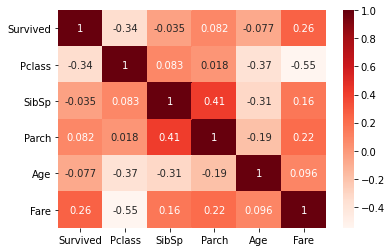

In [18]:
#Se realiza el mismo análisis de manera gráfica. Se quita PassengerId, porque no da valor a la evaluación
sb.heatmap(df_train[["Survived","Pclass","SibSp","Parch","Age","Fare"]].corr(), cmap = "Reds", annot=True)

Se observa que la variable mas correlacionada es **Fare**, esto podría explicarse porque los ricos estaban en las cabinas altas.

También hay que evaluar la Edad y Sexo, pues de esto también dependía quienes eran los primeros en subir a los botes salvavidas

# **Evaluación de variables**

##**Evaluación de Pclass, 1: 1st, 2: 2nd, 3: 3rd**

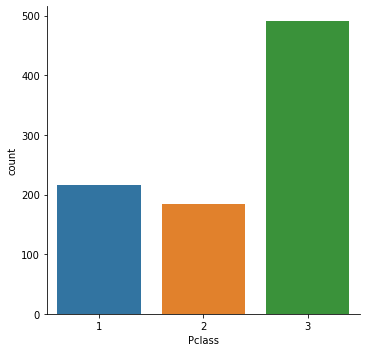

In [19]:
sb.catplot(data=df_train, x="Pclass", kind="count")

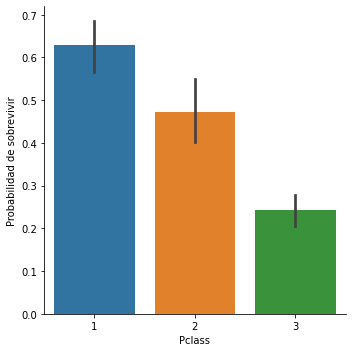

In [20]:
sb.catplot(data=df_train, x="Pclass", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

Se nota que esta variable es importante en el modelo, pues la probabilidad de sobrevivencia de la clase Alta es mayor

## **Evaluación de Sex**

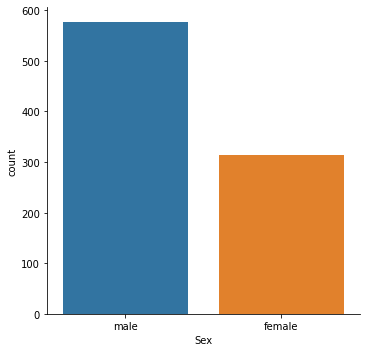

In [21]:
sb.catplot(data=df_train, x="Sex", kind="count")

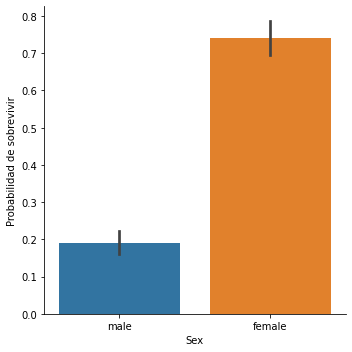

In [22]:
sb.catplot(data=df_train, x="Sex", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

Claramente se observa que la probabilidad de sobrevivir es mayor en las mujeres que en los hombres


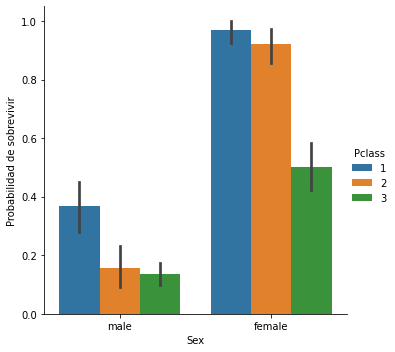

In [23]:
#Evaluemos también como se relaciona la variable Sex, y Pclass
sb.catplot(data=df_train, x="Sex", y="Survived", hue="Pclass", kind="bar").set_ylabels("Probabilidad de sobrevivir")

Se observa que las mujeres siendo de Tercera Clase, sobreviven menos de la mitad

## **Evaluación de Age**

La evaluación se hace tomando grupos de edades

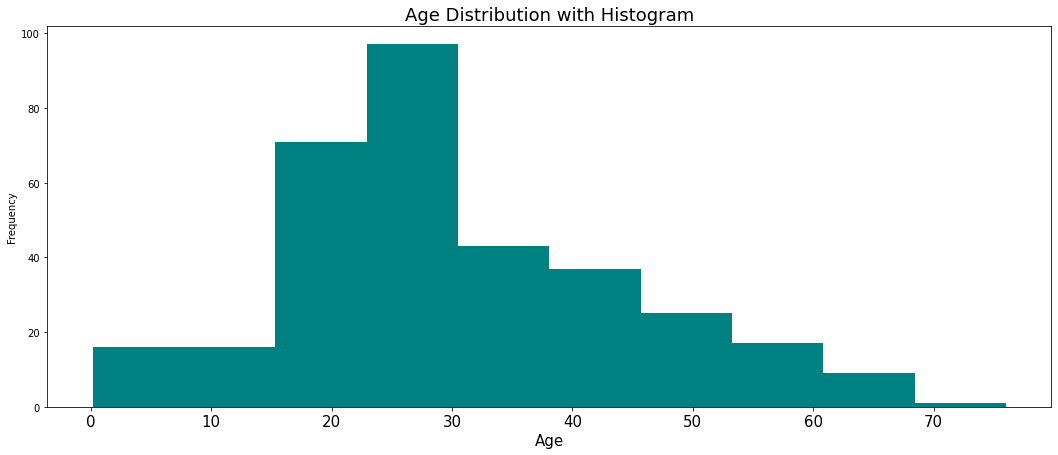

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

In [27]:
#Como age es una variable numérica se emplea un histograma para observar la distribución de sus valores en diferentes rangos
font_size = 15
fig_size = (18, 7)
title_size = 18
ax = df2['Age'].plot.hist(figsize = fig_size, color = 'teal')
plt.xlabel('%s' %df2['Age'].name, fontsize = font_size)
plt.xticks(fontsize = font_size)
plt.title('%s' %df2['Age'].name + ' Distribution with Histogram', fontsize = title_size)
plt.show()

stats = df2['Age'].describe()
display(stats)

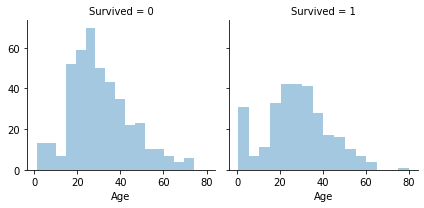

In [24]:
# Revisemos como se comportan los datos No vivos / Vivos
sb.FacetGrid(data=df_train, col='Survived').map(sb.distplot, "Age", kde=False)

Se puede notar claramente que los niños, incluso adolescentes tienen mas probabilidad de sobrevivir. A lo cual se va a crear una nueva variable categórica indicando los "Jóvenes y Adultos"

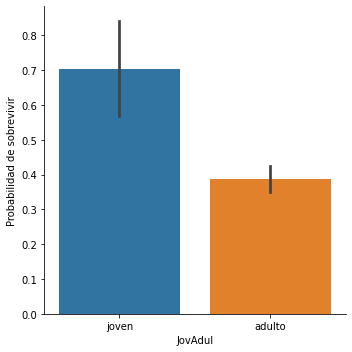

In [25]:
df_train["JovAdul"]= pd.cut(df_train["Age"], bins=[0,5,max(df_train["Age"]+1)], labels=['joven','adulto'])
#Revisamos de igual manera la probabilidad de sobrevivir con esta nueva variable
sb.catplot(data=df_train, x="JovAdul", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

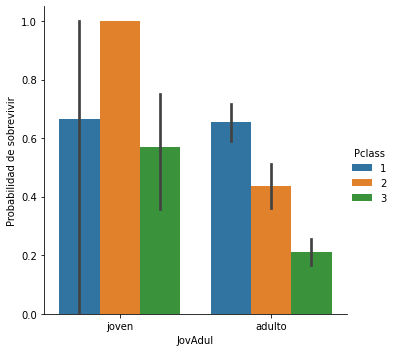

In [26]:
# Se evalúa también como se comporta con la clase social
sb.catplot(data=df_train, x="JovAdul", y="Survived", hue="Pclass", kind="bar").set_ylabels("Probabilidad de sobrevivir")

Al parecer los jóvenes de segunda clase, sobrevivieron igual que los de primera clase, o puede que no habían muchos jóvenes de primera clase

## **Evaluación de Fare**

La matriz de correlación que hemos analizado anteriormente mostró que Fare tiene una fuerte correlación con la posibilidad de sobrevivir. Exploremos la distribución de las tarifas y cómo se correlaciona con la supervivencia.

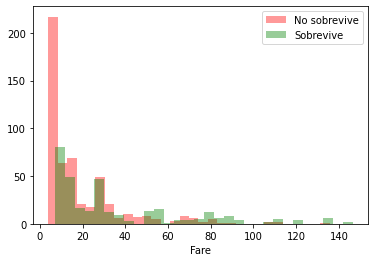

In [28]:
## Para entender mejor la parte de tarifas aplicadas
kde = False
upper = 150 
lower = 0    
Pclass = 0   # 0, para todas las clases

bins=int((upper-lower)/5) 
if Pclass == 1 or Pclass == 2 or Pclass == 3:
    upPclass = Pclass+1
    lowPclass = Pclass
else: 
    upPclass = 4
    lowPclass = 1
    
plt = sb.distplot(df_train["Fare"][(df_train["Survived"] == 0) & (df_train["Fare"]< upper) & (df_train["Fare"]> lower) & (df_train["Pclass"]<upPclass) & (df_train["Pclass"]>=lowPclass)], bins=bins, color="Red", kde=kde)
plt = sb.distplot(df_train["Fare"][(df_train["Survived"] == 1) & (df_train["Fare"]< upper) & (df_train["Fare"]> lower) & (df_train["Pclass"]<upPclass) & (df_train["Pclass"]>=lowPclass)], bins=bins, color="Green", kde=kde)
plt.set_xlabel("Fare")
plt = plt.legend(["No sobrevive","Sobrevive"])

Encontramos algo atípico. Algunos pasajes de tercera clase son mas caros que de primera clase.

In [31]:
df[['Fare','Name','Ticket','SibSp','Parch']].iloc[df.index[(df['Pclass']==3) & (df['Fare']>60)]]

,Fare,Name,Ticket,SibSp,Parch
159,69.55,"Sage, Master. Thomas Henry",CA. 2343,8,2
180,69.55,"Sage, Miss. Constance Gladys",CA. 2343,8,2
201,69.55,"Sage, Mr. Frederick",CA. 2343,8,2
324,69.55,"Sage, Mr. George John Jr",CA. 2343,8,2
792,69.55,"Sage, Miss. Stella Anna",CA. 2343,8,2
846,69.55,"Sage, Mr. Douglas Bullen",CA. 2343,8,2
863,69.55,"Sage, Miss. Dorothy Edith ""Dolly""",CA. 2343,8,2
1079,69.55,"Sage, Miss. Ada",CA. 2343,8,2
1233,69.55,"Sage, Mr. John George",CA. 2343,1,9
1251,69.55,"Sage, Master. William Henry",CA. 2343,8,2


Se nota que los precios altos, se debe a que los pasajes están por toda una familia. Esto es un problema. Entonces trabajemos en crear una nueva variable que indique los costos por separado

In [32]:
# Desviar los valores altos por el número de personas
df_train['FarePers'] = df_train['Fare'].copy()

m = 0
for grp, grp_df in df_train[['Ticket', 'Name', 'Pclass', 'Fare', 'PassengerId']].groupby(['Ticket']):
    if (len(grp_df) != 1):
        if m==0:
            print(grp_df)
            m=1
        for ind, row in grp_df.iterrows():
            passID = row['PassengerId']
            df_train.loc[df_train['PassengerId'] == passID, 'FarePers'] = df_train['Fare'][df_train['PassengerId'] == passID]/len(grp_df)
            

     Ticket  ... PassengerId
257  110152  ...         258
504  110152  ...         505
759  110152  ...         760

[3 rows x 5 columns]


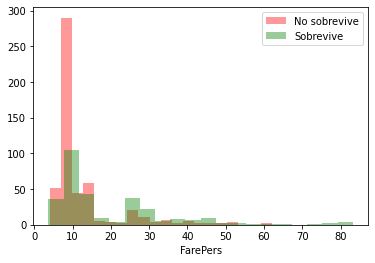

In [33]:
## Volvemos a aplicar, pero con la nueva variable
kde = False
upper = 100
lower = 0    
Pclass = 0   # 0, para todas las clases

bins=int((upper-lower)/5) 
if Pclass == 1 or Pclass == 2 or Pclass == 3:
    upPclass = Pclass+1
    lowPclass = Pclass
else: 
    upPclass = 4
    lowPclass = 1
    
plt = sb.distplot(df_train["FarePers"][(df_train["Survived"] == 0) & (df_train["Fare"]< upper) & (df_train["FarePers"]> lower) & (df_train["Pclass"]<upPclass) & (df_train["Pclass"]>=lowPclass)], bins=bins, color="Red", kde=kde)
plt = sb.distplot(df_train["FarePers"][(df_train["Survived"] == 1) & (df_train["Fare"]< upper) & (df_train["FarePers"]> lower) & (df_train["Pclass"]<upPclass) & (df_train["Pclass"]>=lowPclass)], bins=bins, color="Green", kde=kde)
plt.set_xlabel("FarePers")
plt = plt.legend(["No sobrevive","Sobrevive"])

Haciendo esto, normalizamos la información. Con lo cual se nota que las personas que compraron un pasaje caro, tienen mas probabilidad de sobrevivir.

Vamoa a crear una nueva variable para categorizar según el valor del boleto


In [34]:
df_train['FareCat'] = pd.cut(df_train['FarePers'], bins=[0,15,65,max(df_train["FarePers"]+1)], labels=['bajo','medio','alto'])
df_train['FareCat'].value_counts()

bajo     618
medio    227
alto      31
Name: FareCat, dtype: int64

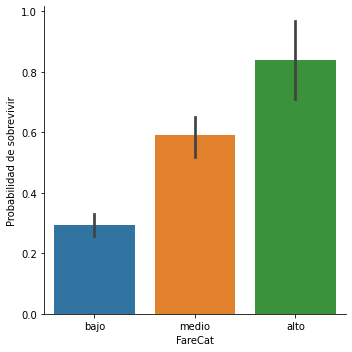

In [35]:
sb.catplot(data=df_train, x="FareCat", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

Con esto conseguimos normalizar y entender mejor esta varaiable


## **Evaluación de Embarked**



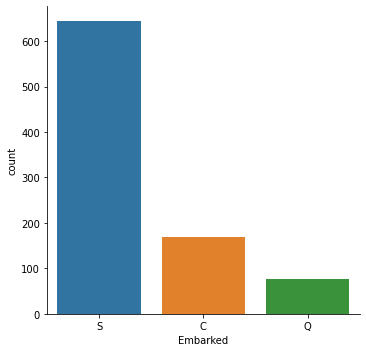

In [36]:
sb.catplot(data=df_train, x="Embarked", kind="count")

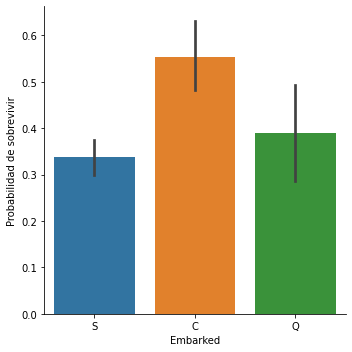

In [37]:
sb.catplot(data=df_train, x="Embarked", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

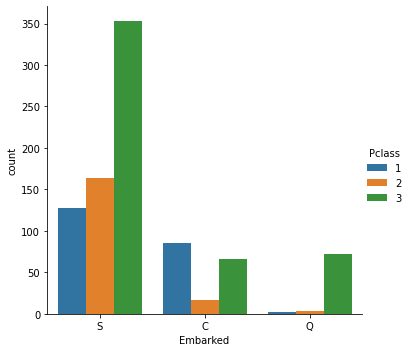

In [38]:
#Se evalua también el total de ingresos, por clase social
sb.catplot(x="Embarked", hue='Pclass',kind="count", data=df_train)

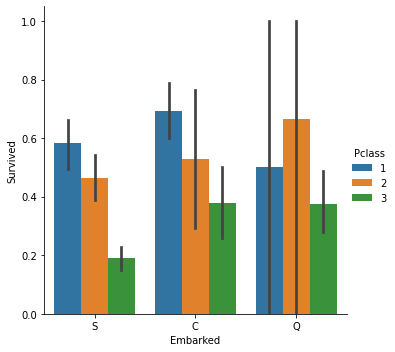

In [39]:
sb.catplot(x="Embarked", y='Survived', hue='Pclass', kind="bar", data=df_train)

La mayoría de los pasajeros embarcaron en Southampton - una mitad en tercera clase, la otra mitad en primera y segunda clase. La mayoría de los pasajeros que embarcaron en Cherburgo viajaron en 1ª clase, lo que explica la mayor probabilidad de supervivencia de este grupo de pasajeros. Es notable que en Queenstwon embarcaron principalmente pasajeros de 3ª clase, sin embargo, su probabilidad de supervivencia es mayor que la de los pasajeros que embarcaron en Southamton


## **Evaluacion de Sibsp y Parch**

In [0]:
# 0 = No sobrevive, 1 = Sobrevive
x0 = df.loc[df.Survived == 0, 'SibSp']
x1 = df.loc[df.Survived == 1, 'SibSp']

y0 = df.loc[df.Survived == 0, 'Parch']
y1 = df.loc[df.Survived == 1, 'Parch']

**¿Hay ausencia de valores o nulos en los pares de variables para ambas categorías?**

In [0]:
null_sum = [x0.isnull().sum(), x1.isnull().sum(), y0.isnull().sum(), y1.isnull().sum()]
count = [x0.count(), x1.count(), y0.count(), y1.count()]

for i, j in zip(null_sum, count):
  print('{} valores nulos en {} observaciones del subconjunto'.format(i, j))

0 valores nulos en 549 observaciones del subconjunto
0 valores nulos en 342 observaciones del subconjunto
0 valores nulos en 549 observaciones del subconjunto
0 valores nulos en 342 observaciones del subconjunto


Al momento, se puede observar una proporción igual en la partición fel par de variables para ambas categorías. 

**Planteamiento: ¿Cuáles son los patrones que hay dentro de cada categoría?**

Considerando la naturaleza discreta de los datos, procederemos a realizar un análisis gráfico para observar la proporción relativa (en %) de cada valor único por cada categoría. 

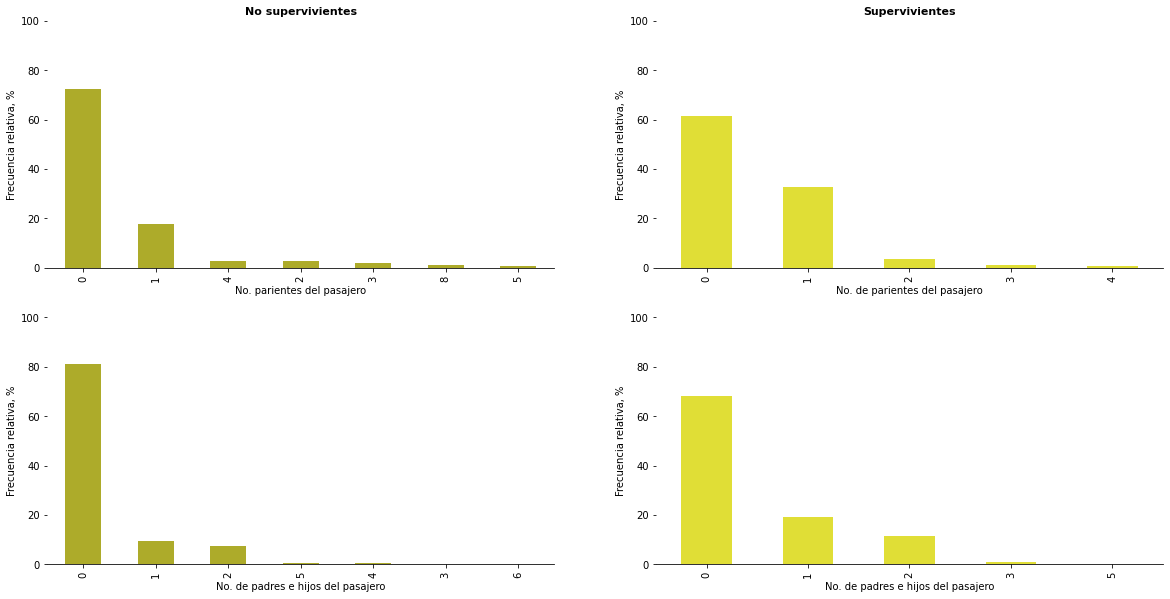

In [0]:
# Creamos un objeto de subplots y establecemos la estructura

fig = plt.figure(figsize=(20,10))

fig.add_subplot(221)
sibsp_m = (100 * x0.value_counts() / len(x0))
ax = sibsp_m.plot.bar(color = '#ADAB2A')
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)
ax.set_title('No supervivientes', **title)
ax.set_ylabel('Frecuencia relativa, %', **labels)
ax.set_xlabel('No. parientes del pasajero', **labels)
ax.set_ylim(0, 100)

fig.add_subplot(222)
sibsp_v = (100 * x1.value_counts() / len(x1))
ax = sibsp_v.plot(kind = 'bar', color ='#E0DE36')
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)
ax.set_title('Supervivientes', **title)
ax.set_ylabel('Frecuencia relativa, %', **labels)
ax.set_xlabel('No. de parientes del pasajero', **labels)
ax.set_ylim(0, 100)

fig.add_subplot(223)
parch_m = (100 * y0.value_counts() / len(y0))
ax = parch_m.plot.bar(color = '#ADAB2A') 
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)
ax.set_ylabel('Frecuencia relativa, %', **labels)
ax.set_xlabel('No. de padres e hijos del pasajero', **labels)
ax.set_ylim(0, 100)

fig.add_subplot(224)
parch_v = (100 * y1.value_counts() / len(y1))
ax = parch_v.plot(kind = 'bar', color ='#E0DE36')
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)
ax.set_ylabel('Frecuencia relativa, %', **labels)
ax.set_xlabel('No. de padres e hijos del pasajero', **labels)
ax.set_ylim(0, 100)

plt.show()

Se observa una proporción muy alta de valores 0 sobre el par de variables, y para ambas categorías. 

**Planteamiento: ¿Habían más solteros que pasajeros con familia en Titanic?**

Crearemos una nueva característica sobre el conjunto de datos que represente el número de familiares o familia del pasajero y observaremos el comportamiento de la variable

In [0]:
df.loc[pd.notnull(df['SibSp']), 'Family'] = df['SibSp'] + df['Parch']

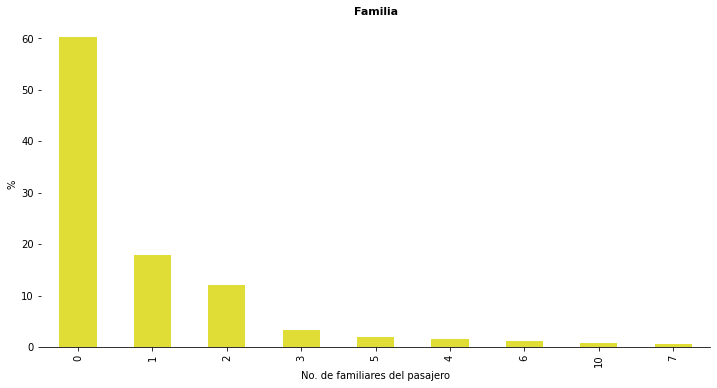

In [0]:
fam = df.Family.value_counts()
fam = 100 * fam / len(df)
ax = fam.plot.bar(figsize=(12, 6), color ='#E0DE36')
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)
ax.set_title('Familia', **title)
ax.set_ylabel('%', **labels)
ax.set_xlabel('No. de familiares del pasajero', **labels)
plt.show()

Efectivamente, la proporción de pasajeros "*solteros*" o sin parientes era mucho mayor que aquella que tenía algún familiar a bordo, decrementando dicha proporción mientras mayor era el número de familiares.

# **Tratamiento de valores nulos**

Se observa que el conjunto de datos $N$ tiene $n: 891$ observaciones y $p: 12$ características, sin embargo ¿Cuántas de estas observaciones están perdidas por los valores nulos? 

**Visualización**

A continuación, se observará gráficamente como se comporta la proporción en función del género. 

In [0]:
def barh(data, query, size):
  """"
  Función que permite graficar barras verticales y comparar entre la población en función del género.
  Esta gráfica está pensada solo para comparar en función del género (variable de segregación) y requiere que esta variable
  se haya codificado como 0: hombre, 1: mujer.  
  """

  segregation = 'Sex'

  fig = plt.figure(figsize=size)

  fig.add_subplot('311')

  g = 100 * data[query].isnull().sum() / len(data)
  # Se calcula los valores nulos como proporción relativa
  # y se crea el gráfico utilizando la funcionalidad de pandas
  ax = g.plot.barh(**{'cmap': cmo.thermal})
  # Se almacena el índice del gráfico actual y se configuran algunos de sus parámetros 
  ax.set_title('% valores nulos en población total', loc='left', **title)
  ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
  ax.set_yticklabels([query[0], query[1]])
  ax.set_xlim(0, 100)
  # Bucle para deshabilitar los spines del gráfico
  spines_off = ['top', 'bottom', 'right']
  for s in spines_off:
    ax.spines[s].set_visible(False)
  # Bucle para añadir la etiqueta alado de la barra
  for k, p in enumerate(g):
    ax.text(p + 1, k, '{}%'.format(int(p)), color= '#8C8C8C', **labels)
  # Bucle para graficar los subplots, se sigue el mismo procedimiento
  for ix, value in enumerate(data[segregation].unique()):

    fig.add_subplot('31' + str(ix+2))

    g = 100 * data.loc[data[segregation] == value, query].isnull().sum() / len(data)
    ax = g.plot.barh(**{'cmap': cmo.thermal})
    gender = {'male': 'hombres', 'female': 'mujeres'}
    ax.set_title('% valores nulos en población de {}'.format(gender[value]), loc='left', **title)
    ax.set_xlim(0, 100)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.set_yticklabels([query[0], query[1]])

    spines_off = ['top', 'bottom', 'right']
    for s in spines_off:
      ax.spines[s].set_visible(False)
  
    for k, p in enumerate(g):
      ax.text(p + 1, k, '{}%'.format(int(p)), color= '#8C8C8C', **labels)
  
  plt.show()

ENTRENAMIENTO


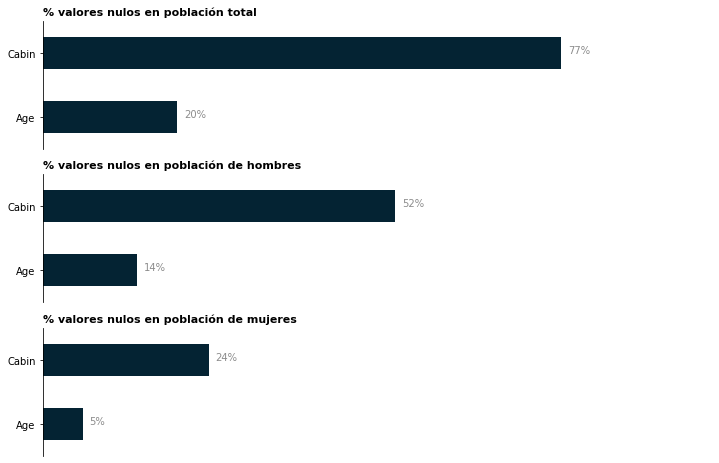

TESTEO


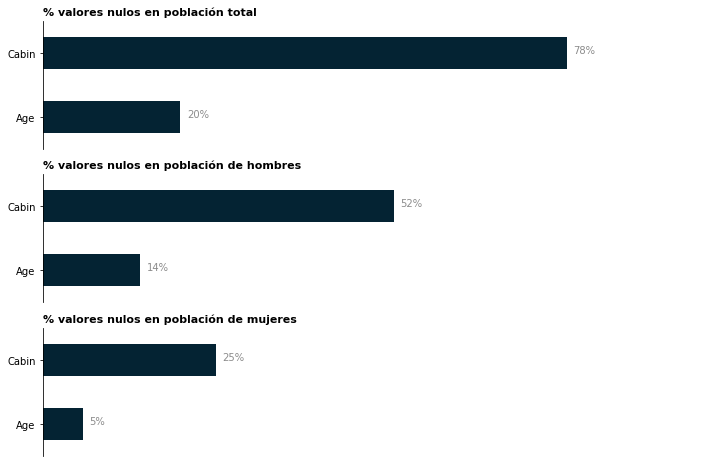

In [0]:
print('ENTRENAMIENTO')
barh(df, query=['Age', 'Cabin'], size=(12, 8))
print('TESTEO')
barh(df2, query=['Age', 'Cabin'], size=(12, 8))

Se observa que la proporción de nulos en $N_{tr}$ y $N_{ts}$, así como sus subconjuntos $H$ y $M$, respectivamente, cumplen la siguiente inecuación: 

$Cabin > Age $

Es decir, hay un número mayor de observaciones nulas en la variable `Cabin` que en `Age`.

## **Una retrospectiva sobre Cabin**

**¿Como se distribuían las cabinas en el Titanic?**

![Plano Transversal del Titanic](https://upload.wikimedia.org/wikipedia/commons/8/84/Titanic_cutaway_diagram.png)

En esta gráfica de vista transversal, se puede observar de forma clara la distribución de los compartimentos del Titanic. La leyenda, muestra 7  categorías que distribuidas desde arriba hacia abajo.



**¿Cuáles son las categorías presentes en nuestro conjunto de datos?**

Antes de solventar esta pregunta, vamos a extraer una muestra aleatoria de la variable `Cabin` para conocer más sobre la misma.

In [0]:
df.Cabin.sample(20)

388     NaN
222     NaN
757     NaN
727     NaN
603     NaN
751    E121
153     NaN
706     NaN
273    C118
418     NaN
624     NaN
249     NaN
83      NaN
606     NaN
345     F33
825     NaN
519     NaN
428     NaN
554     NaN
213     NaN
Name: Cabin, dtype: object

`Cabin` tiene naturaleza categórica nominal, se compone de una letra y un número asociado, posiblemente indicando la sección en la que se encuentra el compartimento ocupado por el pasajero. 

**Planteamiento 1: ¿Cuántos compartimentos puede tener un pasajero?**

In [0]:
# n compartimentos ocupados por un mismo pasajero
col = []
for ix, value in df.Cabin.items():
  try:
    m = re.findall('[A-Z]', value)
    col.append(len(m))
  except:
    pass

max(col)

4

Según el resultado obtenido, el número de compartimentos asociados a un solo pasajero son 4, sin embargo esto solo permite conocer los $n$ compartimentos ocupados sin distinguir si estos se encuentran en la misma sección o no. 

**Planteamiento 2: ¿Cómo se distribuyen los compartimentos en función del estrato socioeconómico?**

In [0]:
df.loc[pd.notnull(df['Cabin']), 'Deck'] = df['Cabin'].str[0]

In [0]:
df.loc[pd.isna(df.Cabin)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Deck,Abv
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,1,NaN,Mr
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,NaN,Miss
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,NaN,Mr
5,6,0,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,NaN,Q,0,NaN,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,S,4,NaN,Master
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,1304,1,3,"Henriksson, Miss. Jenny Lovisa",1,28.0,0,0,347086,7.7750,NaN,S,0,NaN,Miss
1304,1305,0,3,"Spector, Mr. Woolf",0,NaN,0,0,A.5. 3236,8.0500,NaN,S,0,NaN,Mr
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,NaN,Mr
1307,1308,0,3,"Ware, Mr. Frederick",0,NaN,0,0,359309,8.0500,NaN,S,0,NaN,Mr


**Planteamiento 3: ¿Cómo se distribuyen los compartimentos en función del estrato socioeconómico?**

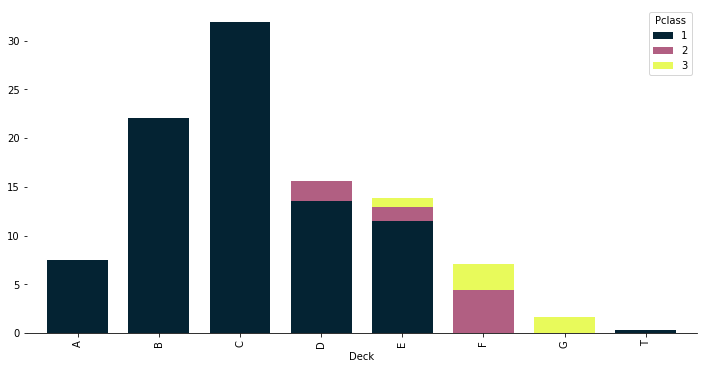

In [0]:
pclass = df.groupby(['Deck', 'Pclass']).count().unstack().PassengerId 
pclass = pclass / pclass.sum().sum() * 100
ax  = pclass.plot.bar(stacked=True, figsize=(12, 6), width=0.75, **{'cmap': cmo.thermal})
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)

**Claves:**

Los pasajeros de **primera clase**, ocuparon 336 de 386 de las habitaciones equivalente al 87% de cuartos disponibles, según los datos disponibles, y se distribuyeron en las cabinas **A**, **B** y **C**.

Los pasajeros de **segunda** y **tercera clase**, ocupaban el 12.95% restante de habitaciones disponibles, y se distribuyeron en las cabinas **D**, **E**, **F** y **G**.


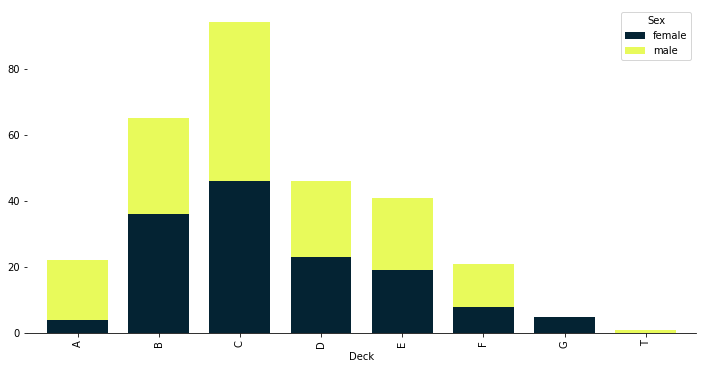

In [0]:
ax = df.groupby(['Deck', 'Sex']).count().unstack().PassengerId.plot.bar(stacked=True, figsize=(12, 6), width=0.75, **{'cmap': cmo.thermal})
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)

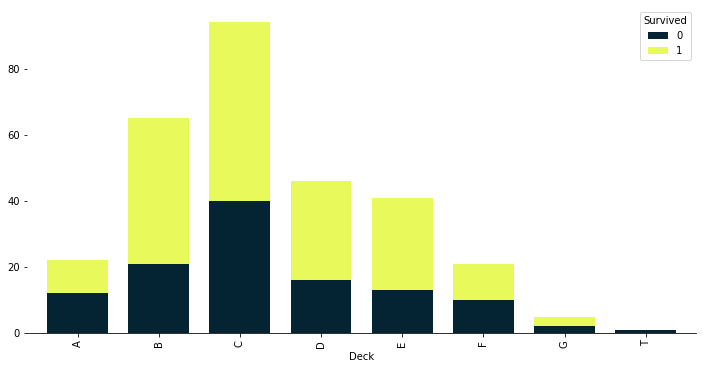

In [0]:
ax = df.groupby(['Deck', 'Survived']).count().unstack().PassengerId.plot.bar(stacked=True, figsize=(12, 6), width=0.75, **{'cmap': cmo.thermal})
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)

# **Creación de variables derivadas**

**Variable derivada del abreviado del género o título**

In [0]:
df["Abv"] = df.Name.str.replace('(.*, )|(\\..*)', '')

# **Análisis de correlación**

## **Usando Phik para obtener una matriz de correlación de variables mixtas**

A menudo los análisis de correlación requerieren de un entendimiento exhaustivo de cada par de variable, con el fin de poder seleccionar la métrica de tamaño de efecto adecuada. Por ejemplo:

* Cuando el par de variables es de naturaleza continuo-continuo, la métrica sería Pearson's R.
* Cuando el par de variables es de naturaleza continuo-categórico: Correlation Ratio.
* Cuando el par de variables es de naturaleza categórico-categóric: Cramer's V or Theil's U.

Para abordar esta problemática, considerando la mixtura de tipos de variables presentes en el conjunto de datos del Titanic, se opta por usar Phik. 

**Takenote:** Phik requerirá de haber completado:
- Tratamiento de valores nulos
- Conversión y derivación de variables

In [0]:
import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

%matplotlib inline

**Definición de la categoría de cada variable**

In [0]:
query = ['Survived', 'Pclass', 'Sex', 'Fare', 'Age', 'Family', 'Embarked', 'Deck', 'Abv']
data = df[query]
data_types = {'Survived': 'categorical',
             'Pclass':'ordinal',
             'Sex':'categorical',
             'SibSp':'interval',
             'Parch':'interval',
             'Fare':'interval',
              'Age': 'interval',
             'Embarked':'categorical',
             'Family':'interval',
              'Deck': 'categorical',
              'Abv': 'categorical'}

interval_cols = [col for col, v in data_types.items() if v=='interval' and col in data.columns]
interval_cols

['Fare', 'Age', 'Family']

**Creación de bines para las variables de intervalo**

In [0]:
data_binned, binning_dict = bin_data(data, cols=interval_cols, retbins=True, bins=8)

/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 320.20575 - 384.2469
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 384.2469 - 448.28805
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 7.499999999999998 - 8.749999999999998
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))


**Visualización de matriz de correlacción**

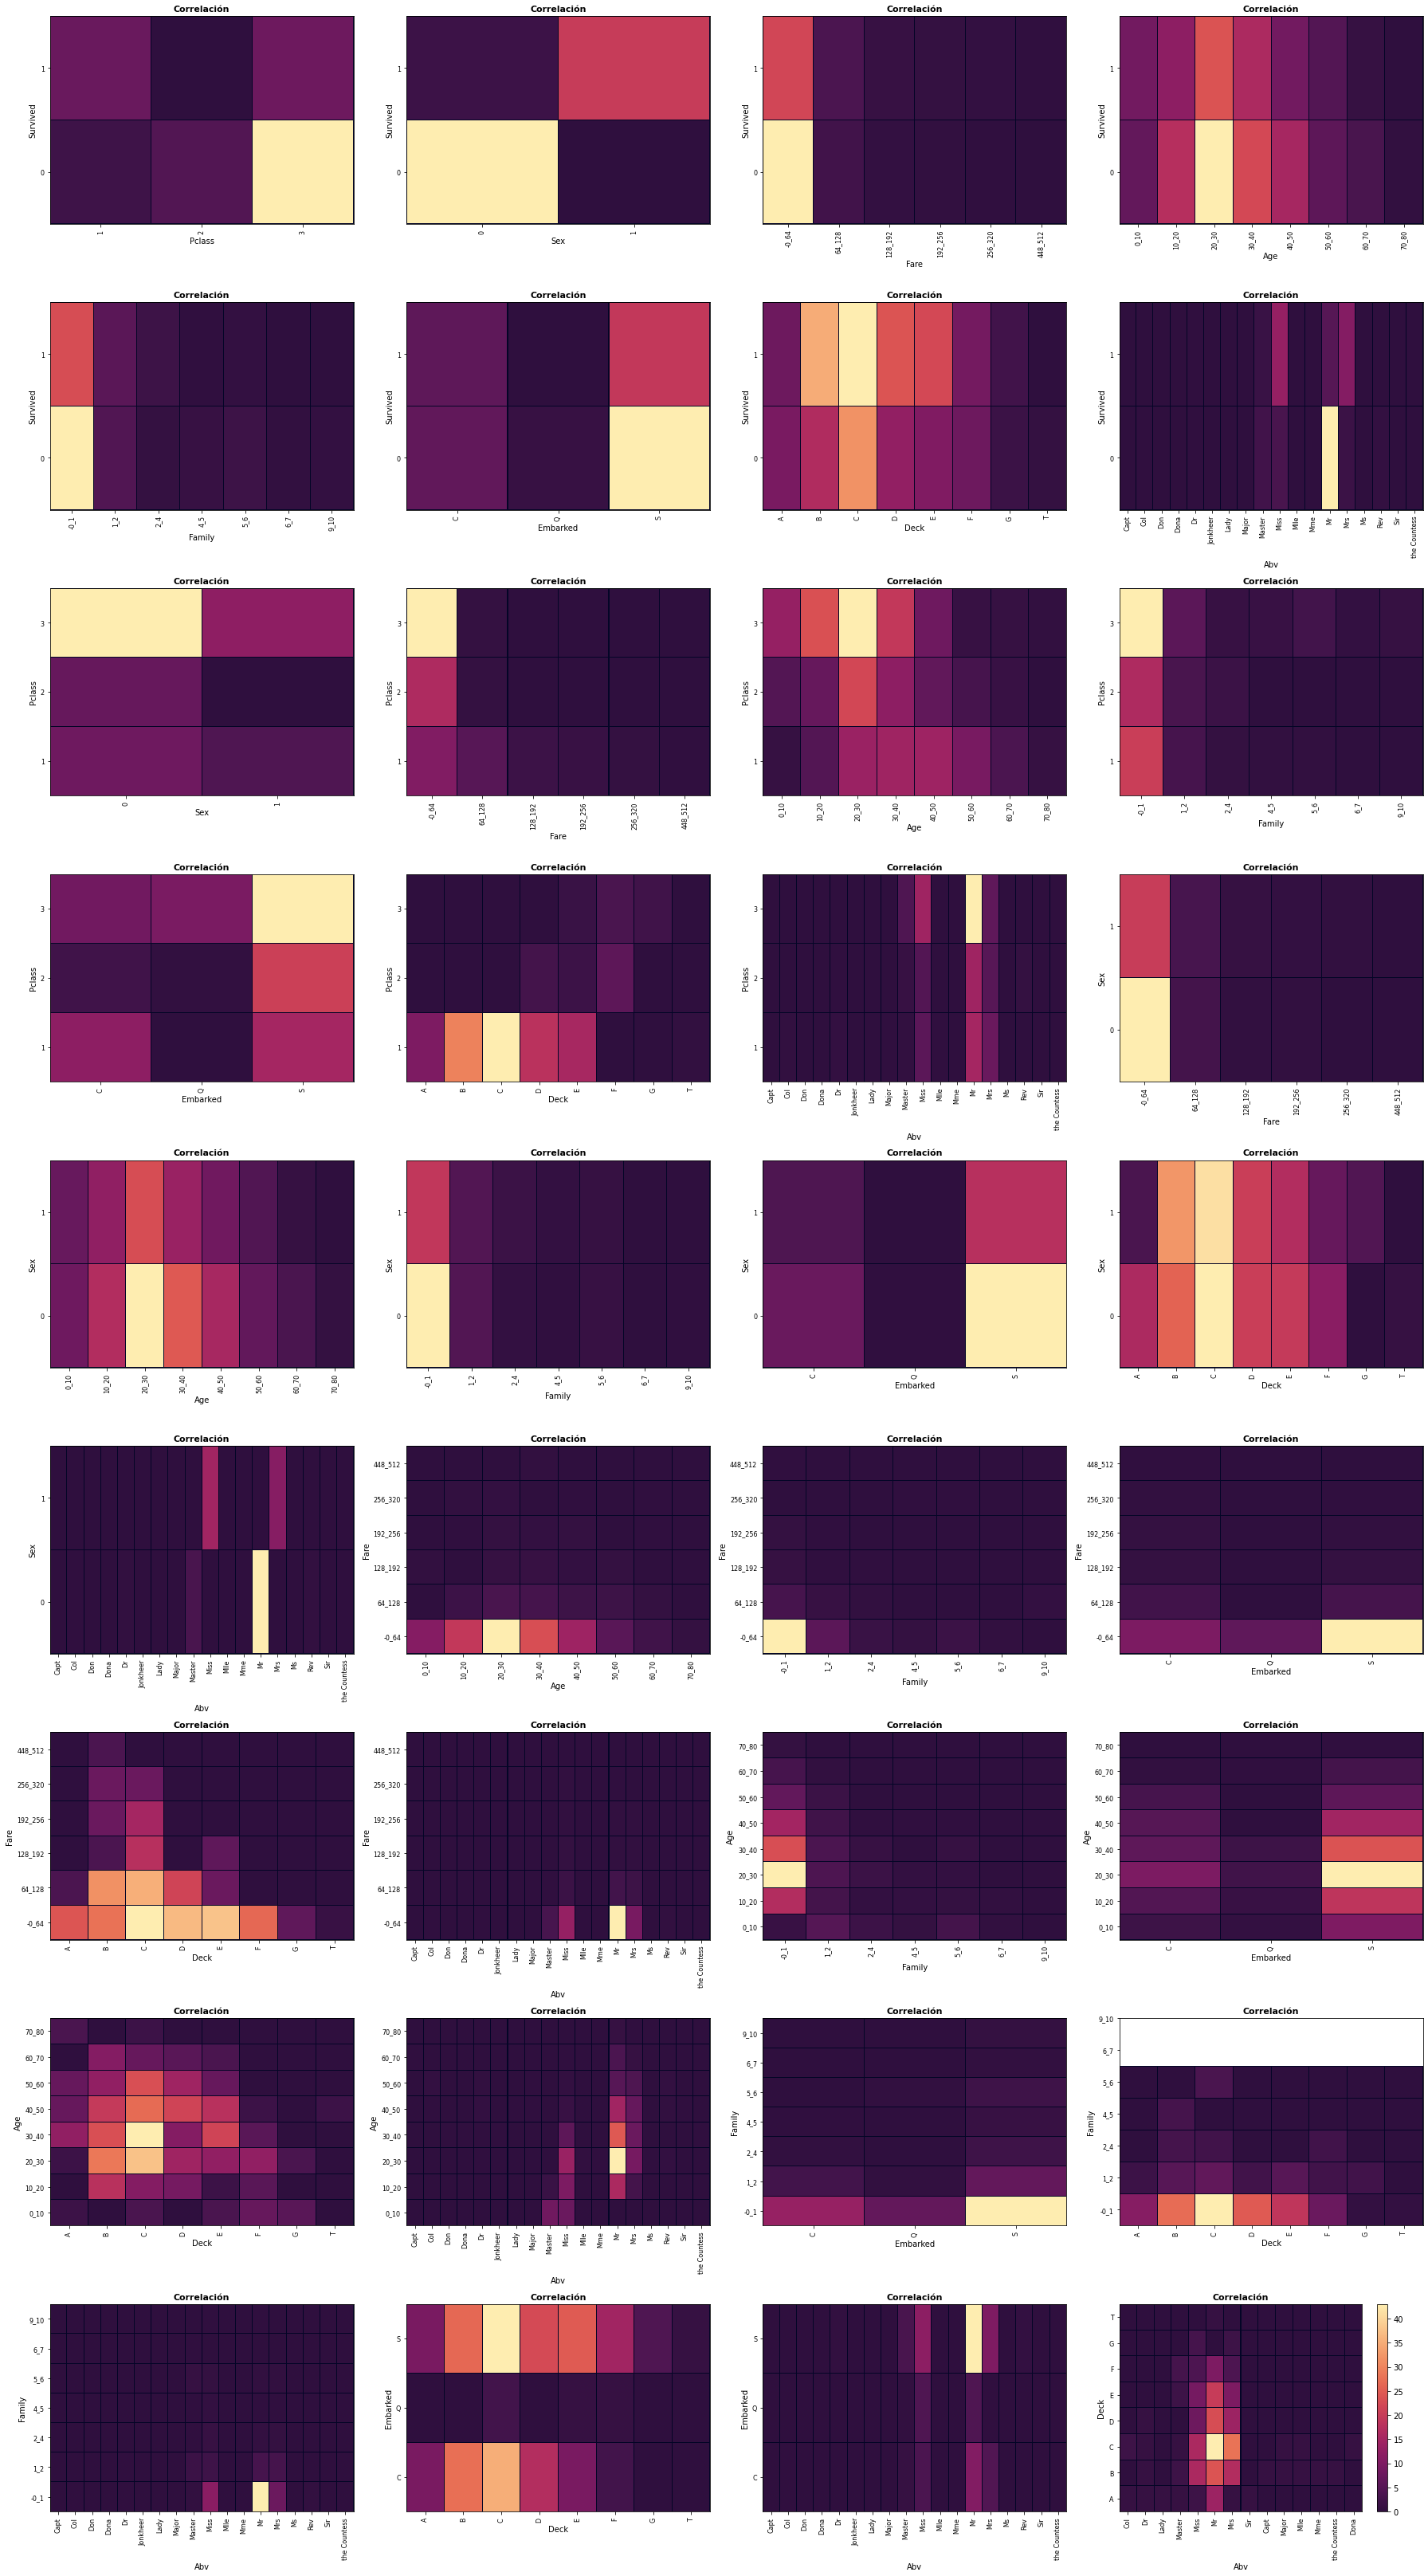

In [0]:
plt.rc('text', usetex=False)

n=0
for i in range(len(data.columns)):
    n+=i
    
ncols=4
nrows=int(np.ceil(n/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(25,5*nrows))
ndecimals = 0

for i, comb in enumerate(itertools.combinations(data_binned.columns.values, 2)):
    
    c = int(i%ncols)
    r = int((i-c)/ncols )

    # datos
    c0, c1 = comb
    datahist = data_binned.groupby([c0,c1])[c0].count().to_frame().unstack().fillna(0)
    datahist.columns = datahist.columns.droplevel()
    
    # gráfico
    img = axes[r][c].pcolormesh(datahist.values, linewidth=0.005, edgecolors='#030526',  **{'cmap': cmo.matter_r})
    
    # etiquetas de sticks
    if c0 in binning_dict.keys():
        ylabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c0][i][0], binning_dict[c0][i][1])
                   for i in range(len(binning_dict[c0]))]
    else:
        ylabels = datahist.index

    if c1 in binning_dict.keys():        
        xlabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c1][i][0], binning_dict[c1][i][1])
                    for i in range(len(binning_dict[c1]))]
    else:
        xlabels = datahist.columns
    
    # etiquetas del eje
    axes[r][c].set_yticks(np.arange(len(ylabels)) + 0.5)
    axes[r][c].set_xticks(np.arange(len(xlabels)) + 0.5)
    axes[r][c].set_xticklabels(xlabels, rotation='vertical', **ticks)
    axes[r][c].set_yticklabels(ylabels, rotation='horizontal', **ticks)    
    axes[r][c].set_xlabel(datahist.columns.name, **labels)
    axes[r][c].set_ylabel(datahist.index.name, **labels)    
    axes[r][c].set_title('Correlación', **title)
    
fig.colorbar(img)

plt.tight_layout()


**Claves para Cabin en función de los valores obtenidos por correlación**:
- Family

Es más probable que siendo soltero (Family: 0),  ocupes el compartimento C, seguido del B o D. 
- Age 

Si ocupas el compartimento B, es más probable que tengas entre 30-40 años, seguido de 20-30 y 40-50, respectivamente.
Si ocupas el compartimento B, es más seguro que tengas entre 20-30, seguido de 30-40 y 10-20, respectivamente. 
- Survived

Es más probable que de si el pasajero sobrevivió y era de género femenino, ocupara el compartimento C, seguido del B y D. 



**Planteamiento 4: ¿Cuáles serían las mejores variables para el llenado de valores nulos sobre Deck?**

/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 307.39752 - 358.63044
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 358.63044 - 409.86336
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 409.86336 - 461.09628
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 7.999999999999999 - 9.0
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))


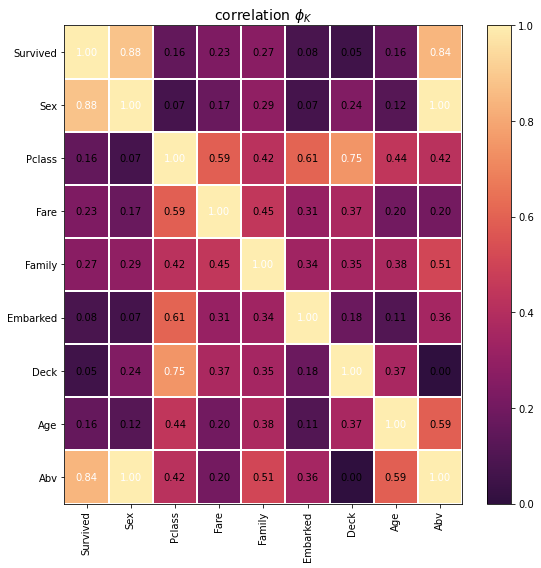

In [0]:
phik_overview = data.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map=cmo.matter_r, title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(8,8))
plt.tight_layout()

## **Usando el método tradicional para analizar la correlación bivariante**

**Planteamiento de la hipótesis nula:** 

El fin del análisis bi-variante es poder resolver la duda de: ¿Existe alguna relación entre una variable $X$ y la supervivencia? 

**$H_{o}:$** No hay dependencia entre las 2 variables categóricas.

**$H_{a}:$** Hay dependencia entre las 2 variables categóricas.

### **Sexo-Superviviencia**

In [0]:
chi_sq = df.Sex.replace({'male': 0, 'female': 1}, inplace=True)

In [0]:
chi_sq = df[['Sex', 'Survived']]

,Sex,Survived
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0


**Paso 1:** Obtener la tabla de contigencia con la función `.crosstab` de `Pandas`.

In [0]:
# Frecuencias observaciones
obs = pd.crosstab(chi_sq.Sex , chi_sq.Survived)

#Chi2, p-valor, grados de libertad, frecuencia esperada
chi_2, p, dof, ex = chi2_contingency(obs)

print('Valor de ji-cuadrado: {}'.format(round(chi_2, 2)))
print('p-valor: {}'.format(p))
print('Grados de libertad: {}'.format(dof))
print('Frecuencia esperada de las observaciones: \n{}'.format(ex.round(2)))

alpha = 0.01 # p-value
cv = chi2.ppf(q= 1-alpha, df= dof)
print('Valor crítico o probabilidad menor de la cola:', cv)

print('Test de independencia entre variables')
if chi_2 >= cv:
  print('- Se rechaza Ho, existe relación entre las 2 variables categóricas.')
else:
  print('- Se retiene Ho, no existe relación entre las 2 variables categóricas')

print('\nTest de significación')
if p <= alpha:
  print('- Se rechaza Ho, existe relación entre las 2 variables categóricas')
else:
  print('- Se retiene Ho, no existe relación entre las 2 variables categóricas')

Valor de ji-cuadrado: 617.31
p-valor: 2.871410444001617e-136
Grados de libertad: 1
Frecuencia esperada de las observaciones: 
[[524.86 318.14]
 [290.14 175.86]]
Valor crítico o probabilidad menor de la cola: 6.6348966010212145
Test de independencia entre variables
- Se rechaza Ho, existe relación entre las 2 variables categóricas.

Test de significación
- Se rechaza Ho, existe relación entre las 2 variables categóricas


In [0]:
def cramers_v(x, y):

  obs = pd.crosstab(x,y)
  chi, p, dof, ex = chi2_contingency(obs)
  n = obs.values.sum()
  r, k = obs.shape
  phi2 = chi / n
  phi2corr = max(0, phi2 - ((k-1) * (r-1)) / (n-1))
  rcorr = r - ((r-1)**2 / (n-1))
  kcorr = k - ((k-1)**2 / (n-1))
  
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [0]:
cramers_v(df.Sex, df.Survived)

0.6864308188858882

In [0]:
tau, p = stats.kendalltau(df.Sex, df.Survived)

print('Valor de Kendall Tau-b: {}'.format(round(tau, 2)))
print('p-valor: {}'.format(p))

Valor de Kendall Tau-b: 0.69
p-valor: 8.2576986696429315e-137


# **Random Forest**